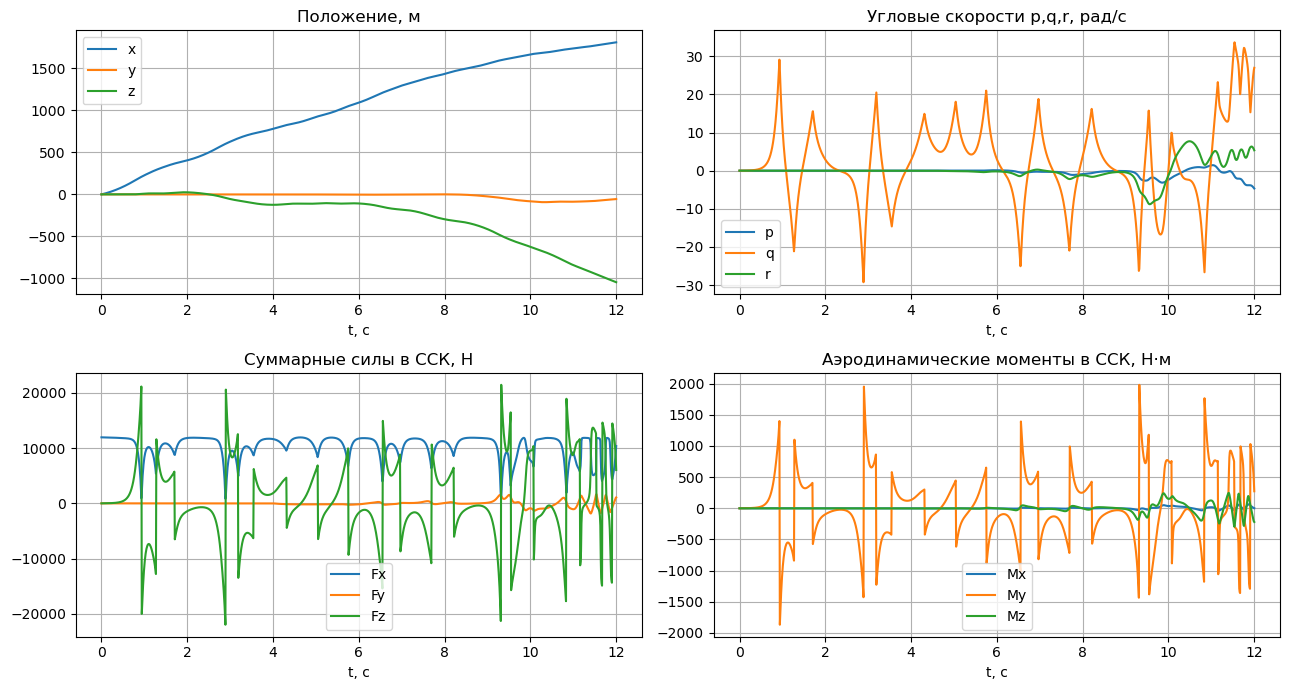

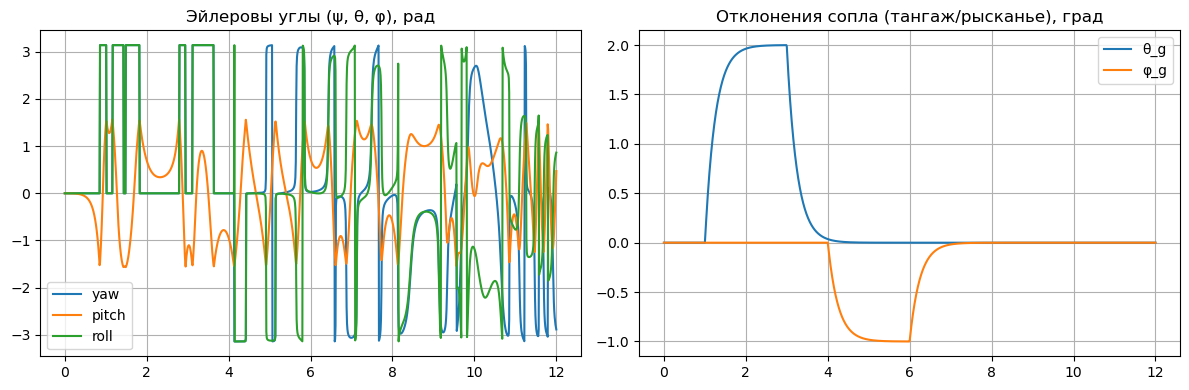

In [8]:



import numpy as np
import matplotlib.pyplot as plt

# ======================
# ПАРАМЕТРЫ СЦЕНАРИЯ
# ======================
g = 9.81
rho = 1.225           # плотность воздуха, кг/м^3 (константа для примера)
S_ref = 0.05          # опорная площадь, м^2
b_ref = 0.50          # размах, м
c_ref = 0.40          # хорда, м

m = 50.0              # масса, кг (в этом примере постоянна)
I = np.diag([5.0, 5.5, 6.0])      # тензор инерции в ССК
I_inv = np.linalg.inv(I)

# -------- Линейные аэродинамические производные (умеренные, со стабилизацией) --------
# моменты
Cl_beta = +0.04
Cl_p    = -7.5

Cm_alpha = -0.6
Cm_q     = -15.0

Cn_beta = +0.25

Cn_r    = -12.0

# силы (очень простая модель)
CD0  = 0.1             # паразитное сопротивление
CDa2 = 0.5             # прирост сопротивления с альфой^2
CL_alpha = 3.0         # подъёмная сила по альфе (в теле: Fz = q S Cz)
CY_beta  = -0.8        # боковая сила по бете

# -------- Тяга и ОДУ управления тягой (гимбал) --------
T_mag = 12000.0        # величина тяги, Н
gimbal_max = np.deg2rad(5.0)   # ограничение отклонения (рад)
tau_gimbal = 0.25                # постоянная времени сервопривода (рад/с)

def guidance_cmd(t):
    """Командные углы отклонения сопла (тангаж, рысканье) в рад.
       Просто небольшой ступенчатый профиль для демонстрации."""
    theta_cmd = np.deg2rad(2.0) if 1.0 < t < 3.0 else 0.0
    phi_cmd   = np.deg2rad(-1.0) if 4.0 < t < 6.0 else 0.0
    return np.clip(theta_cmd, -gimbal_max, gimbal_max), np.clip(phi_cmd, -gimbal_max, gimbal_max)

# ======================
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ПОВОРОТОВ
# ======================
def quat_normalize(q):

    return q/np.linalg.norm(q)

def quat_to_dcm(q):
    """DCM C_BI(q): из ИСК в ССК (так удобно — умножаем v_I -> v_B)."""
    q0,q1,q2,q3 = q
    return np.array([
        [1-2*(q2*q2+q3*q3), 2*(q1*q2-q0*q3),   2*(q1*q3+q0*q2)],
        [2*(q1*q2+q0*q3),   1-2*(q1*q1+q3*q3), 2*(q2*q3-q0*q1)],
        [2*(q1*q3-q0*q2),   2*(q2*q3+q0*q1),   1-2*(q1*q1+q2*q2)]
    ])

def quat_dot(q, omega_b):
    """Кинематика ориентации через кватернион: q' = 0.5 * Omega(ω) * q."""
    p,qb,r = omega_b
    Omega = np.array([
        [0,   -p,  -qb,  -r],
        [p,    0,    r, -qb],
        [qb,  -r,    0,   p],
        [r,   qb,  -p,    0]
    ])
    return 0.5 * Omega @ q

def dcm_to_euler321(C_ib):
    """Для графиков: углы Эйлера (yaw-pitch-roll), 3-2-1 из C_IB."""

    # C_IB вращает B->I; извлекаем yaw ψ, pitch θ, roll φ
    sy = -C_ib[2,0]
    cy = np.sqrt(max(1.0 - sy*sy, 0.0))
    if cy < 1e-8:
        # вырождение
        pitch = np.arcsin(np.clip(sy, -1, 1))
        yaw = 0.0
        roll = np.arctan2(-C_ib[0,1], C_ib[1,1])
    else:
        pitch = np.arcsin(np.clip(sy, -1, 1))
        yaw   = np.arctan2(C_ib[1,0], C_ib[0,0])
        roll  = np.arctan2(C_ib[2,1], C_ib[2,2])
    return np.array([yaw, pitch, roll])

# ======================
# АЭРОДИНАМИКА
# ======================
def aero_coeffs_linear(alpha, beta, pqr, V):
    """Возвращает коэффициенты сил (Cx,Cy,Cz) и моментов (Cl,Cm,Cn)."""
    # демпфированные безразмерные скорости
    p_hat = pqr[0] * b_ref / (2*max(V,1e-6))
    q_hat = pqr[1] * c_ref / (2*max(V,1e-6))
    r_hat = pqr[2] * b_ref / (2*max(V,1e-6))

    # Силы
    Cx = -(CD0 + CDa2*alpha*alpha)
    Cy = CY_beta * beta
    Cz = -CL_alpha * alpha

    # Моменты
    Cl = Cl_beta*beta + Cl_p*p_hat
    Cm = Cm_alpha*alpha + Cm_q*q_hat
    Cn = Cn_beta*beta + Cn_r*r_hat
    return (Cx,Cy,Cz),(Cl,Cm,Cn)

def aero_forces_moments(v_b, pqr):
    """Аэродинамические силы/моменты в ССК."""
    V = np.linalg.norm(v_b)
    if V < 1e-3:
        return np.zeros(3), np.zeros(3)

    alpha = np.arctan2(v_b[2], v_b[0])                  # угол атаки
    beta  = np.arcsin(np.clip(v_b[1]/V, -1.0, 1.0))     # угол скольжения
    q_inf = 0.5 * rho * V*V

    (Cx,Cy,Cz),(Cl,Cm,Cn) = aero_coeffs_linear(alpha, beta, pqr, V)

    F_b = q_inf * S_ref * np.array([Cx, Cy, Cz])
    M_b = q_inf * S_ref * np.array([b_ref*Cl, c_ref*Cm, b_ref*Cn])
    return F_b, M_b

# ======================
# ТЯГА
# ======================
def thrust_body(T, theta_g, phi_g):
    """Вектор тяги в ССК. X — вперёд, Y — вправо, Z — вниз.

       Отклоняем вокруг осей Y (тангаж) и Z (рысканье)."""
    # единичный вектор направления
    cx, sx = np.cos(theta_g), np.sin(theta_g)
    cz, sz = np.cos(phi_g),   np.sin(phi_g)
    # вращаем базовый [1,0,0] сначала по Z(φ), затем по Y(θ)
    # итог: [cosθ cosφ, sinφ, -sinθ cosφ]
    dir_b = np.array([cx*cz, sz, -sx*cz])
    return T * dir_b

# ======================
# ПРАВЫЕ ЧАСТИ ОДУ
# ======================
def translational_rhs(r_i, v_i, q, pqr, F_b_total):
    """Поступательная динамика в ИСК: v' = C_IB F_b/m + g; r' = v."""
    C_bi = quat_to_dcm(q)        # ИСК->ССК
    C_ib = C_bi.T                # ССК->ИСК
    a_i = C_ib @ (F_b_total/m) + np.array([0.0, 0.0, -g])
    return v_i, a_i

def rotational_rhs(q, pqr, M_b_total):
    """Вращательная динамика в ССК: I ω' = M - ω×(Iω); q' = 0.5 Ω(ω) q."""
    omega = pqr
    pqr_dot = I_inv @ (M_b_total - np.cross(omega, I @ omega))
    q_dot = quat_dot(q, omega)
    return q_dot, pqr_dot

# ======================
# ОБЩЕЕ УРАВНЕНИЕ СОСТОЯНИЯ
# x = [r(3), v(3), q(4), pqr(3), theta_g, phi_g]  (в т.ч. динамика сервоприводов)
# ======================
def f_state(t, x):
    r_i = x[0:3]
    v_i = x[3:6]
    q   = quat_normalize(x[6:10])
    pqr = x[10:13]
    theta_g, phi_g = x[13], x[14]

    # скорость в ССК
    C_bi = quat_to_dcm(q)
    v_b = C_bi @ v_i

    # аэродинамика
    F_aero_b, M_aero_b = aero_forces_moments(v_b, pqr)

    # тяга (управляемая)
    Ttheta_cmd, Tphi_cmd = guidance_cmd(t)
    # динамика серво (1-го порядка):  θ' = (θ_cmd - θ)/τ
    theta_g_dot = (np.clip(Ttheta_cmd, -gimbal_max, gimbal_max) - theta_g)/tau_gimbal
    phi_g_dot   = (np.clip(Tphi_cmd,   -gimbal_max, gimbal_max) - phi_g)/tau_gimbal

    F_thr_b = thrust_body(T_mag, theta_g, phi_g)
    M_thr_b = np.zeros(3)  # для примера считаем, что вектор тяги через ЦМ (без плеча)


    F_b = F_aero_b + F_thr_b
    M_b = M_aero_b + M_thr_b

    # правые части
    r_dot, v_dot = translational_rhs(r_i, v_i, q, pqr, F_b)
    q_dot, pqr_dot = rotational_rhs(q, pqr, M_b)

    # собрать в один вектор производных
    dx = np.zeros_like(x)
    dx[0:3]   = r_dot
    dx[3:6]   = v_dot
    dx[6:10]  = q_dot
    dx[10:13] = pqr_dot
    dx[13]    = theta_g_dot
    dx[14]    = phi_g_dot
    return dx

# ======================
# RK4 (фиксированный шаг)
# ======================
def rk4_step(fun, t, x, dt):
    k1 = fun(t, x)
    k2 = fun(t + 0.5*dt, x + 0.5*dt*k1)
    k3 = fun(t + 0.5*dt, x + 0.5*dt*k2)
    k4 = fun(t + dt,     x + dt*k3)
    x_new = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    # нормализуем q
    x_new[6:10] = quat_normalize(x_new[6:10])
    # ограничим углы гімбала

    x_new[13] = np.clip(x_new[13], -gimbal_max, gimbal_max)
    x_new[14] = np.clip(x_new[14], -gimbal_max, gimbal_max)
    return x_new

# ======================
# СИМУЛЯЦИЯ
# ======================
dt = 0.01
t_end = 12.0
N = int(t_end/dt)+1
t_arr = np.linspace(0.0, t_end, N)

# начальные условия
r0 = np.array([0.0, 0.0, 0.0])
v0 = np.array([120.0, 0.0, 0.0])          # стартовая скорость вдоль X
q0 = np.array([1.0, 0.0, 0.0, 0.0])       # без начального крена
pqr0 = np.array([0.0, 0.0, 0.0])
theta_g0, phi_g0 = 0.0, 0.0

x = np.zeros(15)
x[0:3]   = r0
x[3:6]   = v0
x[6:10]  = q0
x[10:13] = pqr0
x[13]    = theta_g0
x[14]    = phi_g0

# логи
r_log   = np.zeros((N,3))

v_log   = np.zeros((N,3))
pqr_log = np.zeros((N,3))
euler_log = np.zeros((N,3))
F_log = np.zeros((N,3))
M_log = np.zeros((N,3))
gimbal_log = np.zeros((N,2))

for i,t in enumerate(t_arr):
    # лог перед шагом (чтобы соответствовать t)
    r_log[i]   = x[0:3]
    v_log[i]   = x[3:6]
    pqr_log[i] = x[10:13]
    C_ib = quat_to_dcm(x[6:10]).T
    euler_log[i] = dcm_to_euler321(C_ib)
    # силы/моменты в текущем состоянии (для логов)
    v_b = quat_to_dcm(x[6:10]) @ x[3:6]
    F_aero_b, M_aero_b = aero_forces_moments(v_b, x[10:13])
    F_thr_b = thrust_body(T_mag, x[13], x[14])
    F_log[i] = F_aero_b + F_thr_b
    M_log[i] = M_aero_b
    gimbal_log[i] = [x[13], x[14]]

    if i < N-1:
        x = rk4_step(f_state, t, x, dt)

# ======================
# ГРАФИКИ
# ======================
plt.figure(figsize=(13,7))

plt.subplot(2,2,1)
plt.plot(t_arr, r_log)
plt.title("Положение, м")
plt.xlabel("t, c"); plt.grid(True)
plt.legend(["x","y","z"])

plt.subplot(2,2,2)
plt.plot(t_arr, pqr_log)
plt.title("Угловые скорости p,q,r, рад/с")
plt.xlabel("t, c"); plt.grid(True)
plt.legend(["p","q","r"])

plt.subplot(2,2,3)
plt.plot(t_arr, F_log)
plt.title("Суммарные силы в ССК, Н")
plt.xlabel("t, c"); plt.grid(True)
plt.legend(["Fx","Fy","Fz"])

plt.subplot(2,2,4)
plt.plot(t_arr, M_log)
plt.title("Аэродинамические моменты в ССК, Н·м")
plt.xlabel("t, c"); plt.grid(True)
plt.legend(["Mx","My","Mz"])

plt.tight_layout()
plt.show()

# Доп. график ориентации и гимбала
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

plt.plot(t_arr, euler_log)
plt.title("Эйлеровы углы (ψ, θ, φ), рад")
plt.grid(True); plt.legend(["yaw","pitch","roll"])
plt.subplot(1,2,2)
plt.plot(t_arr, np.rad2deg(gimbal_log))
plt.title("Отклонения сопла (тангаж/рысканье), град")
plt.grid(True); plt.legend(["θ_g","φ_g"])
plt.tight_layout(); plt.show()
